In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [234]:
# Base path
BASE_DIR = "/Users/akshatha/GeorgakopoulosSoaresLab/g4_analysis"
SPECIES_DATA = f"{BASE_DIR}/results/species_data.csv"
G4_DIST = f"{BASE_DIR}/results/g4hunter_g4_distribution.csv"
GFF_DATA = f"{BASE_DIR}/results/gff_feature_data.csv"

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

In [235]:
# read species data
df_species = pd.read_csv(f"{BASE_DIR}/results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "GC Percentage", "Taxa", "Kingdom", "Phylum"]]
df_species = df_species.replace('na', np.nan)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.set_index('Accession', inplace=True)
# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_species = df_species[df_species["Taxa"] != "metagenomes"]
df_species = df_species[df_species["Taxa"] != "other"]
# for viruses, set kingdom as virus
df_species.loc[df_species["Taxa"] == "viral", "Kingdom"] = "Virus"

# read g4 distribution data
df_dist = pd.read_csv(G4_DIST)
df_dist.set_index('accession', inplace=True)
df_dist = df_dist[['gene', 'exon', 'CDS', 'total_g4_length', 'g4_count']]
# rename columns
df_dist.columns = ['G4s in Genes', 'G4s in Exons', 'G4s in CDS', 'Total G4 Length', 'G4 Count']

# read gff data
df_gff = pd.read_csv(GFF_DATA)
df_gff.set_index('accession', inplace=True)
df_gff = df_gff[['gene', 'exon', 'CDS']]
# rename columns
df_gff.columns = ['Genes', 'Exons', 'CDS']

# merge dataframes on index (accession)
df_g4 = df_species.join(df_dist, how='inner')
df_g4 = df_g4.join(df_gff, how='inner')
df_g4.reset_index(inplace=True)
df_g4.rename(columns={'index': 'Accession'}, inplace=True)

# drop rows where phylum is NaN as they are not relevant for phylum level analysis
df_g4.dropna(subset=['Phylum'], inplace=True)

# drop rows where Genes, Exons or CDS is NaN
# since these are the main features we are interested in for G4 analysis
df_g4.dropna(subset=['Genes', 'Exons', 'CDS'], inplace=True)

# replace NaN with 0 for G4s in Genes, Exons, CDS, Total G4 Length and G4 Count
# as these represent no G4s in the respective features
df_g4.fillna(0, inplace=True)

In [236]:
# calculate G4 densities by feature
df_g4['G4 Density per Mb: Genome'] = df_g4['Total G4 Length']/df_g4['Genome Size'] * 1000000
df_g4['G4 Density per Mb: Gene'] = df_g4['G4s in Genes']/df_g4['Genes'] * 1000000
df_g4['G4 Density per Mb: Exon'] = df_g4['G4s in Exons']/df_g4['Exons'] * 1000000
df_g4['G4 Density per Mb: CDS'] = df_g4['G4s in CDS']/df_g4['CDS'] * 1000000
df_g4.sort_values(by='G4 Density per Mb: Genome', ascending=False, inplace=True)
df_g4.to_csv(f'{BASE_DIR}/results/g4hunter_combined_dist_data.csv', index=False)

In [237]:

# group by domain and get mean of all columns starting with "Type:"
df_domain = df_g4.groupby('Domain').agg(
    {col: 'mean' for col in df_g4.columns if col.startswith('G4 Density per Mb: ')}
)

# create new dataframe for grouped domain plots
df_domain_plot = df_g4[['Domain', 'G4 Density per Mb: Genome', 'G4 Density per Mb: Gene', 'G4 Density per Mb: Exon', 'G4 Density per Mb: CDS']]
df_domain_plot = df_domain_plot.melt(id_vars=['Domain'], var_name='Feature', value_name='G4 Density per Mb')
df_domain_plot['Feature'] = df_domain_plot['Feature'].apply(lambda x: x.split(': ')[1])
df_domain_grouped = df_domain_plot.groupby(['Domain', 'Feature']).agg({
    'G4 Density per Mb': 'mean'
    })
df_domain_grouped['std error'] = df_domain_plot.groupby(['Domain', 'Feature']).agg({
    'G4 Density per Mb': 'sem'
    })
df_domain_grouped.rename(columns={'G4 Density per Mb': 'Average G4 Density per Mb'}, inplace=True)
df_domain_grouped['log10(Average G4 Density)'] = np.log10(df_domain_grouped['Average G4 Density per Mb']+1)
df_domain_grouped.reset_index(inplace=True)
df_domain_grouped.head()

,Domain,Feature,Average G4 Density per Mb,std error,log10(Average G4 Density)
0,Archaea,CDS,5651.177385,273.603424,3.752216
1,Archaea,Exon,22389.402452,1160.988302,4.350062
2,Archaea,Gene,5727.235149,274.464216,3.758021
3,Archaea,Genome,6210.882854,283.440579,3.793223
4,Bacteria,CDS,4082.549095,34.402963,3.611038


<Figure size 1000x1000 with 0 Axes>

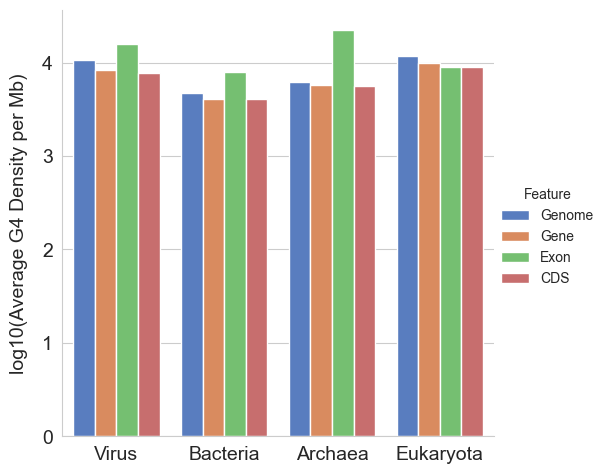

In [238]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 10))

# order of categories
domain_order = ["Virus", "Bacteria", "Archaea", "Eukaryota"]
feature_order = ['Genome', 'Gene', 'Exon', 'CDS']

# plot
sns.catplot(
    data=df_domain_grouped, 
    kind="bar",
    x="Domain", 
    y="log10(Average G4 Density)", 
    hue="Feature",
    order=domain_order,
    hue_order=feature_order,
    palette='muted'
)

# formatting
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('')
plt.ylabel('log10(Average G4 Density per Mb)', fontsize=14, labelpad=10)
plt.savefig(f'{BASE_DIR}/plots/feature_domain_g4_density_g4hunter.png') 

In [239]:
# create new dataframe for grouped phylum plots
df_phylum_plot = df_g4[['Domain', 'Phylum', 'G4 Density per Mb: Genome', 'G4 Density per Mb: Gene', 'G4 Density per Mb: Exon', 'G4 Density per Mb: CDS']]
df_phylum_plot = df_phylum_plot.melt(id_vars=['Domain', 'Phylum'], var_name='Feature', value_name='G4 Density per Mb')
df_phylum_plot['Feature'] = df_phylum_plot['Feature'].apply(lambda x: x.split(': ')[1])

df_heatmap = df_phylum_plot.pivot_table(index=['Domain', 'Phylum'], columns=['Feature'], values='G4 Density per Mb', aggfunc='mean')
df_heatmap = df_heatmap.apply(lambda x: np.log10(x+1))
df_heatmap = df_heatmap[['Genome', 'Gene', 'Exon', 'CDS']]

# get number of species for each phylum
df_phylum_count = df_phylum_plot.pivot_table(index=['Domain', 'Phylum'], values='G4 Density per Mb', aggfunc='count')
df_phylum_count.rename(columns={'G4 Density per Mb': 'Count'}, inplace=True)
# divide by 4 to get the number of species (since we have 4 features for each species)
df_phylum_count['Count'] = df_phylum_count['Count'] / 4
df_phylum_count = df_phylum_count.astype(int)

# filter out phyla with less than 5 species
df_heatmap = df_heatmap.join(df_phylum_count, how='inner')
df_heatmap.sort_values(by='Count', ascending=True, inplace=True)
print(df_heatmap.shape)
df_heatmap = df_heatmap[df_heatmap['Count'] >= 5]
print(df_heatmap.shape)
df_heatmap.head()
df_heatmap.drop(columns=['Count'], inplace=True)

(109, 5)
(55, 5)


/var/folders/qb/4ylt6z0d6tb4k4dfqtp35dbh0000gn/T/ipykernel_24626/1208971290.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


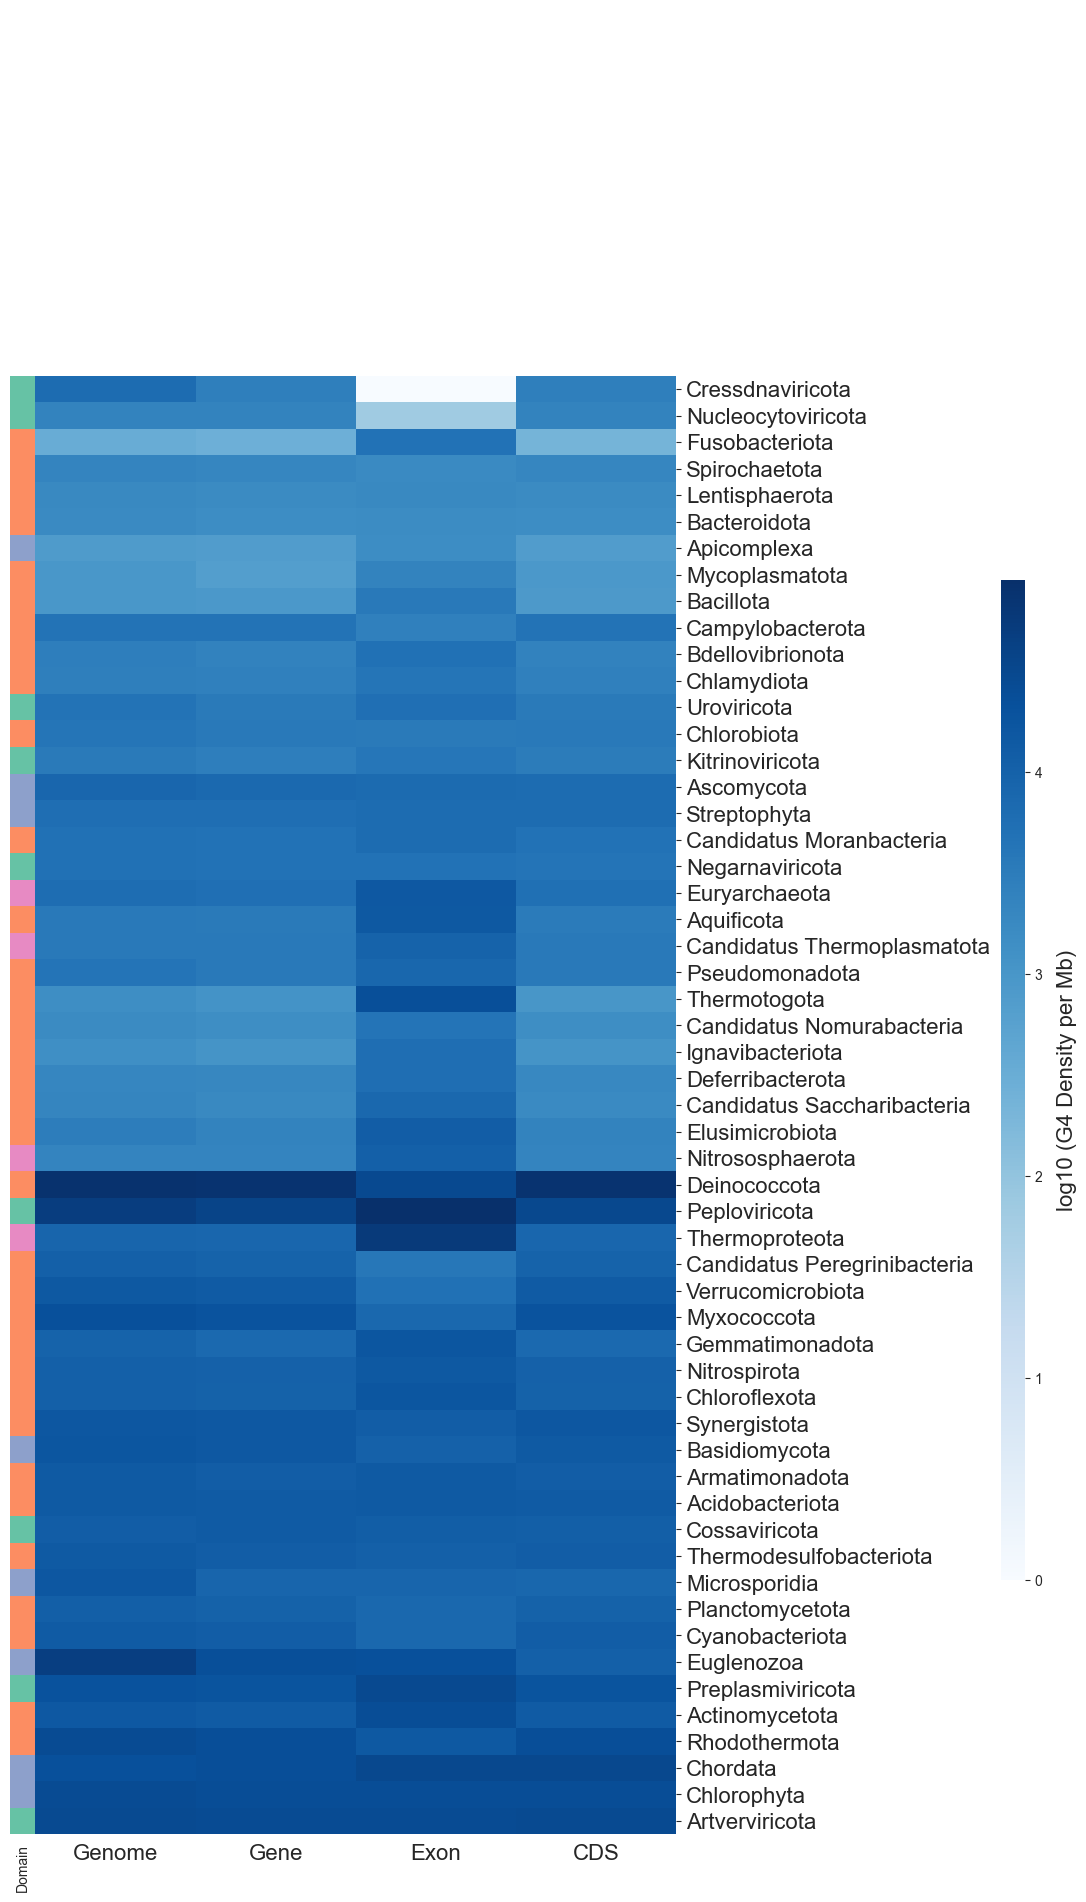

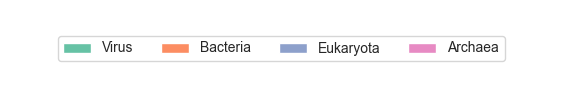

In [248]:
# clustermap with phylum on y-axis and genomic feature on x-axis
domains = df_heatmap.index.get_level_values("Domain")
domain_colors = pd.Series(domains, index=df_heatmap.index).map(color_map)

# add numerical values to heatmap
g = sns.clustermap(
    df_heatmap,
    xticklabels=True,
    yticklabels=True,
    col_cluster=False,
    row_cluster=True,
    row_colors=domain_colors,
    cmap="Blues",
)

# hide dendrograms
g.ax_row_dendrogram.set_visible(False)

# formatting labels
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=16)
ylabels = [str(x).split('-')[1].replace("')", "") for x in g.ax_heatmap.get_yticklabels()]
g.ax_heatmap.set_yticklabels(ylabels, fontsize=16)

# set colorbar position
plt.gcf().axes[-1].set_position([0.98, 0.2, .02, .5])
plt.gcf().axes[-1].set_ylabel('log10 (G4 Density per Mb)', labelpad=10, fontsize=16)
plt.gcf().set_size_inches(12, 20)

plt.tight_layout()
plt.savefig(f'{BASE_DIR}/plots/feature_vs_phylum_g4_density_g4hunter.png', bbox_inches='tight')

# create a legend for domain colors
fig, ax = plt.subplots()
fig.set_size_inches(7, 1)
for domain, color in color_map.items():
    ax.bar(domain, 0, color=color, label=domain)
# set label font size
ax.legend(fontsize=16)
ax.legend(loc='center', ncol=4)
plt.axis('off')
plt.savefig(f'{BASE_DIR}/plots/domain_color_legend.png', bbox_inches='tight')